# Augmentation d'image - Shear - 2/2 - 0
## Objectif
L'objectif de ce notebook est de tester l'ajout de shear aux images lors du formatage sur le jeu de données de l'étude avec les autres parametres.

## Hypothèses

- La suppression du cisaiilement va appauvrire la diversité et réduire la performance

## Etapes de la démarche
1. Modifier la fonction de formatage des images pour y ajouter du zoom
2. Tester le jeu de données avec l'algo CNN
3. Calculer les métriques de performance
4. Comparer les résultats avec les résultats du template aug_control_v1

## Interprétation des résultats et Conclusion
Les résultats obtenus sont les suivants :

- La cross validation ne montre pas d’inconsistence
- Les performances du modele sont similaires à celles du modele témoin avec des faux positif un peu moins importants
- La heatmap indique que le modele fixe les zones  pertinentes des images

In [1]:
# Check that GPU is used
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:

# Chargez les variables d'environnement

TRAIN_FOLDER = 'train'
TEST_FOLDER = 'test'
VAL_FOLDER = 'val'

TRAIN_AUGMENTED_FOLDER = 'train_augmented'
ITERATION = 'v2.0'
# Define the subfolders within each folder where the images are stored
subfolders = ['NORMAL', 'PNEUMONIA']

# Define the size of the images you want to resize your images to
img_width, img_height = 128, 128  # Function to load and resize images from a folder

In [3]:
# Fonction de chargement des images des dataset et des labels associés
def load_images_from_folder(folder, limit_per_subfolder=None):
    X = []
    y = []
    for subfolder in subfolders:
        folder_path = os.path.join(folder, subfolder)
        if limit_per_subfolder:
            # Get amount of random filenames from the folder
            filenames = np.random.choice(os.listdir(folder_path), limit_per_subfolder, replace=False)
        else:
            filenames = os.listdir(folder_path)
        for filename in filenames:
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)

            # Resize the image to the desired size
            img = img.resize((img_width, img_height))

            # Convert RGB image to grayscale
            img = img.convert('L')

            # Convert the image to a NumPy array and append it to X
            img = np.array(img)
            X.append(img)

            # Append the corresponding label to y
            y.append(subfolders.index(subfolder))

    X = np.array(X)
    y = np.array(y)
    return X, y

In [4]:
import os
import numpy as np
from PIL import Image, ImageOps
from keras.preprocessing.image import ImageDataGenerator

def generate_augmented_images(folder, to_augment_class, image_size=(128, 128), target_nbr=5000):
    dir = os.path.join(folder, to_augment_class)
    count = len(os.listdir(dir))

    augmented_dir = os.path.join(f"{folder}_augmented_{ITERATION}", to_augment_class)

    if not os.path.exists(f"{folder}_augmented_{ITERATION}"):
        os.mkdir(f"{folder}_augmented_{ITERATION}")

    if not os.path.exists(augmented_dir):
        os.mkdir(augmented_dir)

    augmented_count = len(os.listdir(augmented_dir))

    datagen = ImageDataGenerator(

            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'

    )

    generator = datagen.flow_from_directory(

        folder,
        batch_size=1,
        save_to_dir=augmented_dir,
        save_format='jpeg',
        save_prefix='IM_AUGMENTED',
        classes=[to_augment_class],
        # keep_aspect_ratio=True,
        target_size=image_size,
    )

    additional_count = target_nbr - len(os.listdir(augmented_dir))

    for i in range(additional_count):
        generator.next()

    new_count = len(os.listdir(augmented_dir))

    print(f'Given {to_augment_class} count: {count}')
    print(f'Augmented {to_augment_class} count: {new_count}')

In [5]:

generate_augmented_images(TRAIN_FOLDER, 'NORMAL', image_size=(img_width, img_height))
generate_augmented_images(TRAIN_FOLDER, 'PNEUMONIA', image_size=(img_width, img_height))


Found 1341 images belonging to 1 classes.
Given NORMAL count: 1341
Augmented NORMAL count: 5000
Found 3875 images belonging to 1 classes.
Given PNEUMONIA count: 3876
Augmented PNEUMONIA count: 5000


In [6]:
# Load the training data
# Get min value between the number of normal images and the number of pneumonia images
TRAIN_FOLDER = f"{TRAIN_AUGMENTED_FOLDER}_{ITERATION}"

TEST_FOLDER = f"{TEST_FOLDER}"
VAL_FOLDER = f"{VAL_FOLDER}"

min_images = min(len(os.listdir(os.path.join(TRAIN_FOLDER, subfolders[0]))),
                 len(os.listdir(os.path.join(TRAIN_FOLDER, subfolders[1]))))
X_train, y_train = load_images_from_folder(TRAIN_FOLDER, min_images)

# Load the test data
X_test, y_test = load_images_from_folder(TEST_FOLDER)

# Load the validation data
X_val, y_val = load_images_from_folder(VAL_FOLDER)

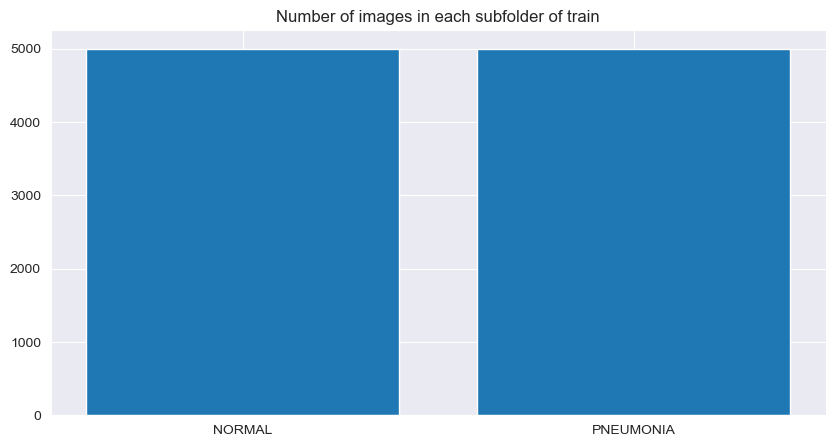

In [7]:
# Make a matplot figure to show how many images are in each subfolder of train
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(os.listdir(os.path.join(TRAIN_FOLDER, subfolder))) for subfolder in subfolders])
plt.title('Number of images in each subfolder of train')
plt.show()

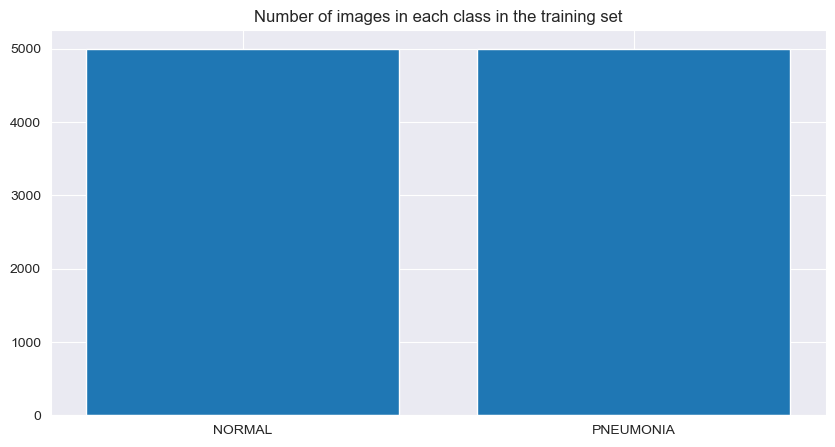

In [8]:
# Make a matplot figure to show how many images if each class in the training set
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(y_train[y_train == i]) for i in range(len(subfolders))])
plt.title('Number of images in each class in the training set')
plt.show()

In [9]:
# Normalize the pixel values to be between 0 and 1
num_samples = X_train.shape[0]
print(X_test.shape)
X_train = X_train.reshape(len(X_train), img_width, img_height, 1)
X_test = X_test.reshape(len(X_test), img_width, img_height, 1)
X_val = X_val.reshape(len(X_val), img_width, img_height, 1)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

print('done \n')

(624, 128, 128)
done 



(128, 128, 1)


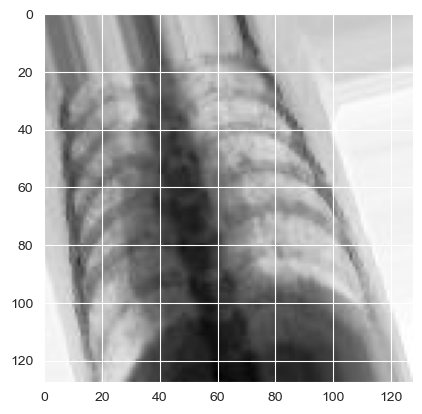

In [10]:
single_image = X_train[np.random.randint(len(X_train))]
print(single_image.shape)
plt.imshow(single_image, cmap='Greys')

In [11]:
# Define model metrics
from keras.metrics import AUC

metrics = [
    "accuracy",
    AUC(name='auc')
]

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Define the model architecture
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(img_width, img_height, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation="sigmoid"))

    # compile the model
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=metrics)

    return model

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [14]:
# Cross validation
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from h5py import File
# Define the number of folds for cross-validation
n_splits = 10
epochs = 7
batch_size =64

# Initialize KFold with the number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define lists to store the evaluation scores for each fold
accuracy_scores = []
og_val_accuracy_scores = []
histories = []
models = []
fold_no = 1
best_score = float('inf')  # pour une tâche de minimisation
best_model = None
# Iterate through each fold and train/evaluate the model
for train_idx, val_idx in kf.split(X_train, y_train):
    # Split the data into training and validation sets for this fold
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

    # Create an instance of ImageDataGenerator to generate your image data
    datagen = ImageDataGenerator()

    # Create generators for training and validation data
    train_generator = datagen.flow(x=X_train_fold, y=y_train_fold, batch_size=batch_size)
    valid_generator = datagen.flow(x=X_val_fold, y=y_val_fold, batch_size=batch_size)

    # Create instance of the model for this fold and train it
    model = create_model()

    # Train your model on the training data for this fold
    history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, verbose=1,
                        callbacks=[early_stop])
    # Model Évaluation with original val dataset
    scores = model.evaluate(X_val, y_val, verbose=1)
    og_val_accuracy_scores.append(scores[1])
    print(f'\nScore for fold with orginal val dataset {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%\n')

    histories.append(history.history)

    models.append(model)

    # After training, evaluate the model on the validation set for this fold
    accuracy = model.evaluate(X_val_fold, y_val_fold)[1]

    # Store the accuracy score in the list
    accuracy_scores.append(accuracy)

    # Print the accuracy for this fold
    print(f"Accuracy for fold {len(accuracy_scores)}: {accuracy * 100}%")

    # Check if the model is better than the previous
    if scores[0] < best_score:
        best_score = scores[0]
        best_model = model

    fold_no = fold_no + 1

    # Sauvegarde du meilleur modèle
    if best_model is not None:
        best_model.save(f'cnn_best_cv_{ITERATION}.h5')

# Calculate and print the average accuracy over all folds
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
og_val_average_accuracy = sum(og_val_accuracy_scores) / len(og_val_accuracy_scores)
print(f"\nAverage accuracy: {average_accuracy * 100}%")
print(f"\nAverage accuracy with orginal val: {og_val_average_accuracy * 100}%")

Epoch 1/7
141/141 [==============================] - 14s 70ms/step - loss: 0.5355 - accuracy: 0.7180 - auc: 0.8065 - val_loss: 0.3840 - val_accuracy: 0.8290 - val_auc: 0.9244
Epoch 2/7
141/141 [==============================] - 9s 61ms/step - loss: 0.3148 - accuracy: 0.8700 - auc: 0.9373 - val_loss: 0.2765 - val_accuracy: 0.8890 - val_auc: 0.9583
Epoch 3/7
141/141 [==============================] - 8s 60ms/step - loss: 0.2430 - accuracy: 0.9077 - auc: 0.9621 - val_loss: 0.2402 - val_accuracy: 0.9010 - val_auc: 0.9667
Epoch 4/7
141/141 [==============================] - 9s 60ms/step - loss: 0.2121 - accuracy: 0.9199 - auc: 0.9708 - val_loss: 0.2019 - val_accuracy: 0.9180 - val_auc: 0.9744
Epoch 5/7
141/141 [==============================] - 8s 59ms/step - loss: 0.1833 - accuracy: 0.9351 - auc: 0.9777 - val_loss: 0.1859 - val_accuracy: 0.9280 - val_auc: 0.9794
Epoch 6/7
141/141 [==============================] - 9s 60ms/step - loss: 0.1583 - accuracy: 0.9418 - auc: 0.9832 - val_loss: 0.1

In [15]:
# Get accuracy scores for each fold (train and validation)
loss = []
acc = []
val_loss = []
val_acc = []

for history in histories:
    loss.append(np.mean(history["loss"]))
    acc.append(np.mean(history["accuracy"]))
    val_loss.append(np.mean(history["val_loss"]))
    val_acc.append(np.mean(history["val_accuracy"]))

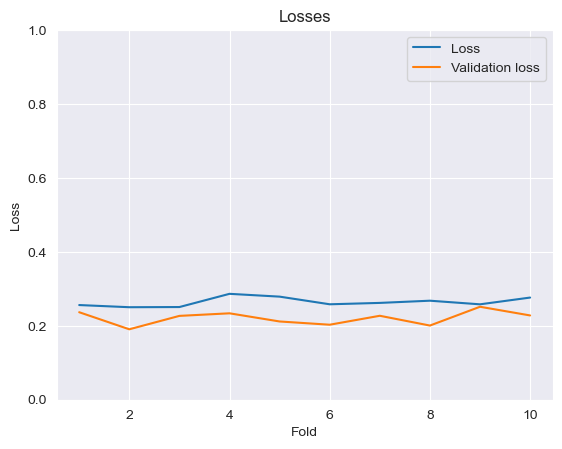

In [16]:
# Plot loss and validation loss per fold
import matplotlib.pyplot as plt
plt.title('Losses')
plt.plot(range(1, len(loss)+1), loss, label='Loss')
plt.plot(range(1, len(val_loss)+1), val_loss, label='Validation loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.show()

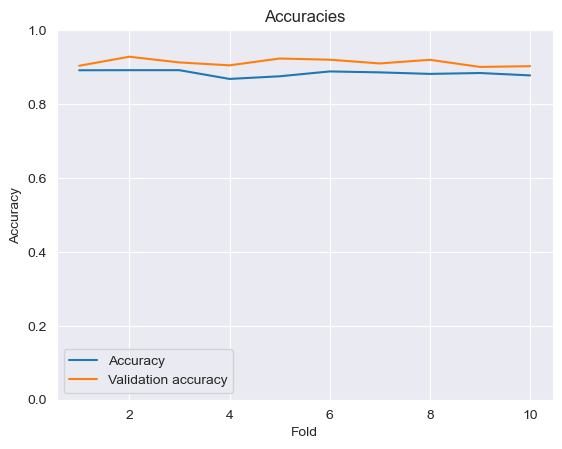

In [17]:
# Plot accuracies and validation accuracies per fold
import matplotlib.pyplot as plt

plt.title('Accuracies')
plt.plot(range(1, len(acc) + 1), acc, label='Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation accuracy')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
# Train a final model with same parameters and save it
# Create an instance of ImageDataGenerator to generate your image data
datagen = ImageDataGenerator()
train_generator = datagen.flow(x=X_train, y=y_train, batch_size=batch_size)
valid_generator = datagen.flow(x=X_val, y=y_val, batch_size=batch_size)
model = create_model()
history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, verbose=1, callbacks=[early_stop])
model.save(f'cnn_{ITERATION}.h5')

Epoch 1/7
157/157 [==============================] - 10s 60ms/step - loss: 0.5037 - accuracy: 0.7196 - auc: 0.8436 - val_loss: 0.4152 - val_accuracy: 0.8125 - val_auc: 0.9219
Epoch 2/7
157/157 [==============================] - 9s 57ms/step - loss: 0.2943 - accuracy: 0.8825 - auc: 0.9450 - val_loss: 0.4396 - val_accuracy: 0.7500 - val_auc: 0.8828
Epoch 3/7
157/157 [==============================] - 9s 57ms/step - loss: 0.2622 - accuracy: 0.9004 - auc: 0.9565 - val_loss: 0.4901 - val_accuracy: 0.6875 - val_auc: 0.8750
Epoch 4/7
157/157 [==============================] - 9s 56ms/step - loss: 0.2115 - accuracy: 0.9205 - auc: 0.9716 - val_loss: 0.4259 - val_accuracy: 0.8125 - val_auc: 0.9219
Epoch 5/7
157/157 [==============================] - 9s 56ms/step - loss: 0.1918 - accuracy: 0.9312 - auc: 0.9766 - val_loss: 0.6003 - val_accuracy: 0.7500 - val_auc: 0.8438
Epoch 6/7
157/157 [==============================] - 9s 56ms/step - loss: 0.1622 - accuracy: 0.9405 - auc: 0.9829 - val_loss: 0.3

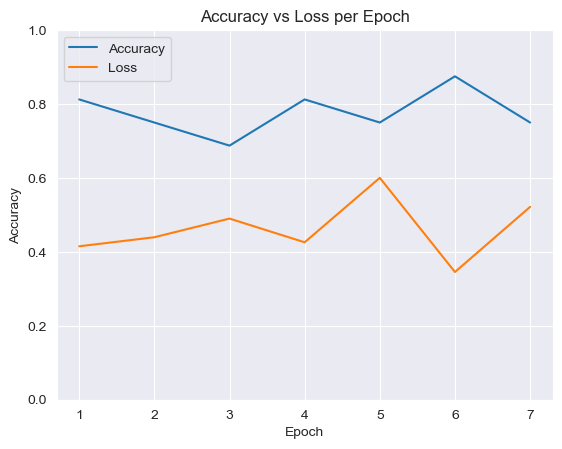

In [19]:
# Plot val accuracy and val loss of the trained model
import matplotlib.pyplot as plt

plt.title('Accuracy vs Loss per Epoch')
plt.plot(range(1, len(history.history["val_accuracy"]) + 1), history.history["val_accuracy"], label='Accuracy')
plt.plot(range(1, len(history.history["val_loss"]) + 1), history.history["val_loss"], label='Loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
from tensorflow.keras.models import load_model
# Make predictions on the test set
model = load_model(f'cnn_{ITERATION}.h5')

In [21]:

# Make predictions on the test set

y_pred_test = model.predict(X_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

20/20 [==============================] - 0s 8ms/step


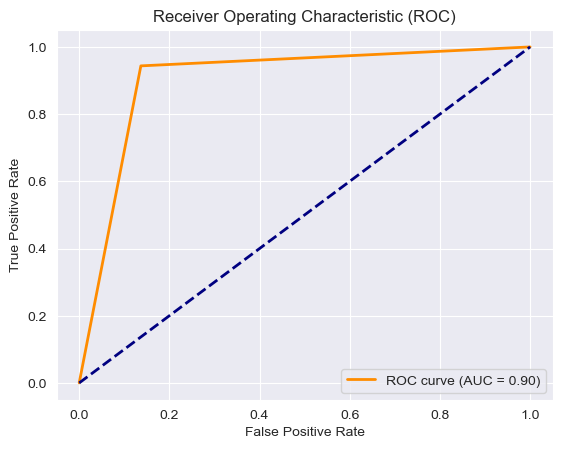

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC score for the predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and show AUC score on the plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test.flatten())
print(cm)

[[202  32]
 [ 22 368]]


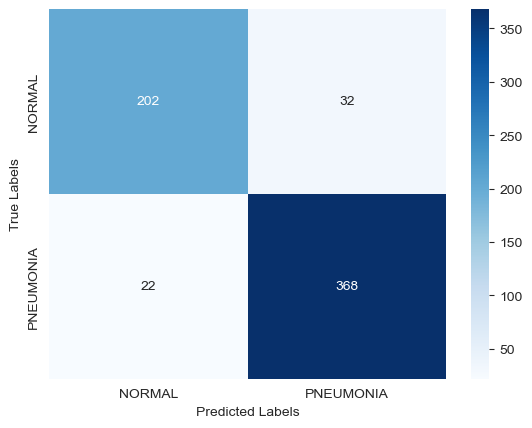

In [24]:
# Plot the confusion matrix
class_names = subfolders
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [25]:
# Compute the classification report for test set
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.90      0.86      0.88       234
   PNEUMONIA       0.92      0.94      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.91       624
weighted avg       0.91      0.91      0.91       624



In [26]:
# Remove last layer's softmax
model.layers[-1].activation = None

# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [27]:
# Print model summary to get last max pooling layer name
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 14, 14, 128)    

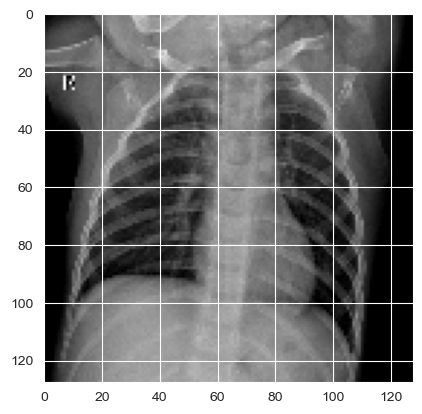

C:\ProgramData\anaconda3\envs\env\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


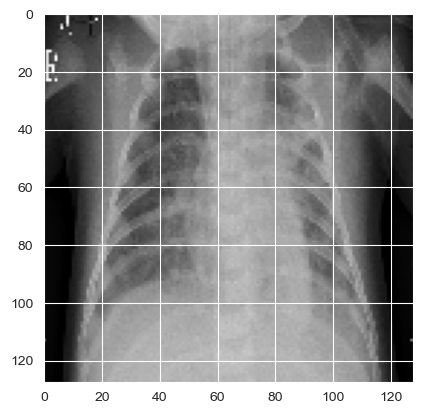

In [28]:
from common.cam import get_img_array
from common.cam import get_img_array
# Heatmaps and Grad-CAM


import cv2
import matplotlib.pyplot as plt

images = [
    {
        "path": "./val/NORMAL/NORMAL2-IM-1442-0001.jpeg"
    },
    {
        "path": "./val/PNEUMONIA/person1946_bacteria_4874.jpeg"
    }
]

for image in images:
    image_temp = cv2.imread(image["path"])
    image_temp = cv2.cvtColor(image_temp, cv2.COLOR_RGB2GRAY)
    image_temp = cv2.resize(image_temp, (img_width, img_height))

    plt.imshow(image_temp, cmap=plt.cm.gray)
    plt.show()

    image["array"] = get_img_array(image["path"], size=(img_width, img_height))


In [29]:
# Select last conv layer
last_conv_layer_name = "max_pooling2d_43"

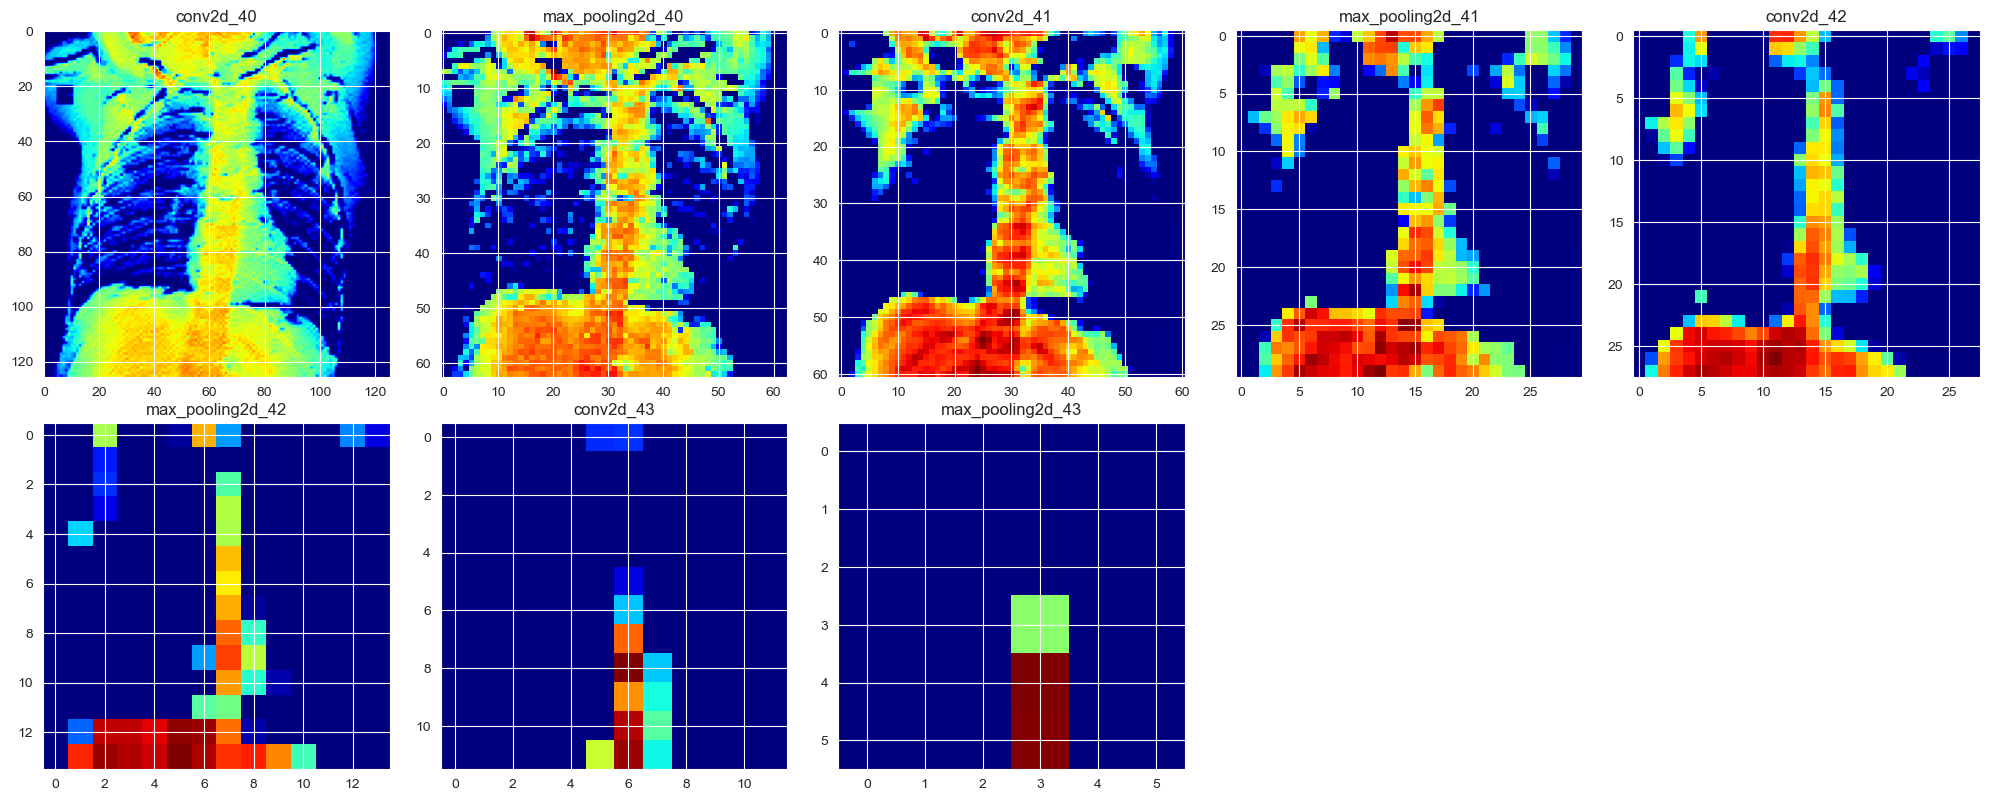

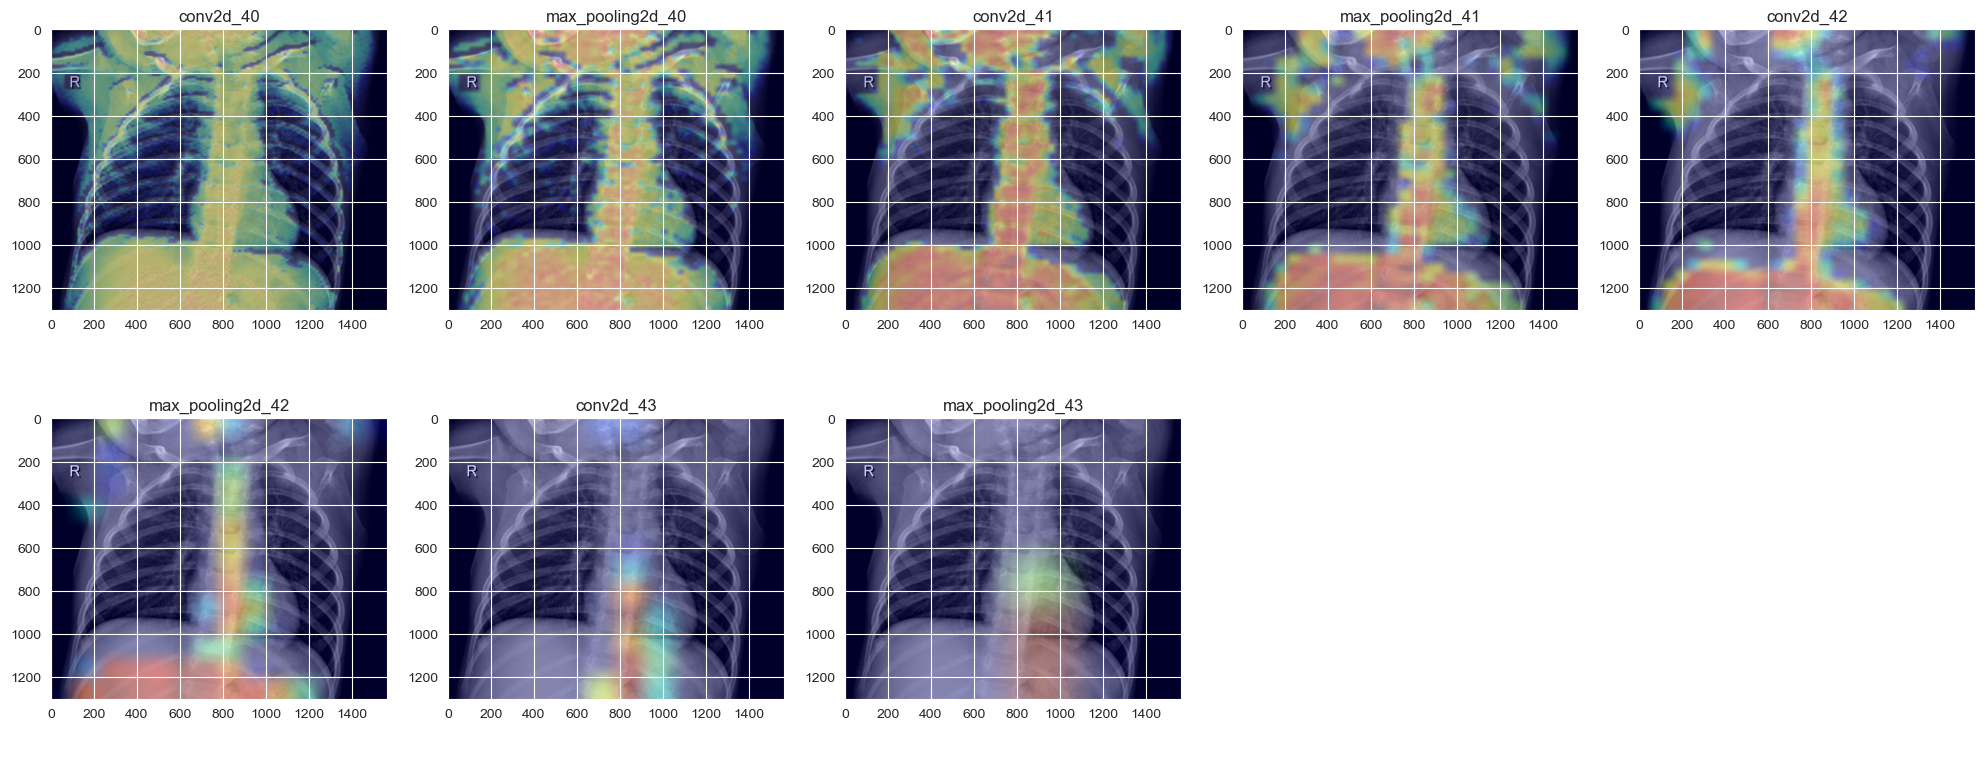

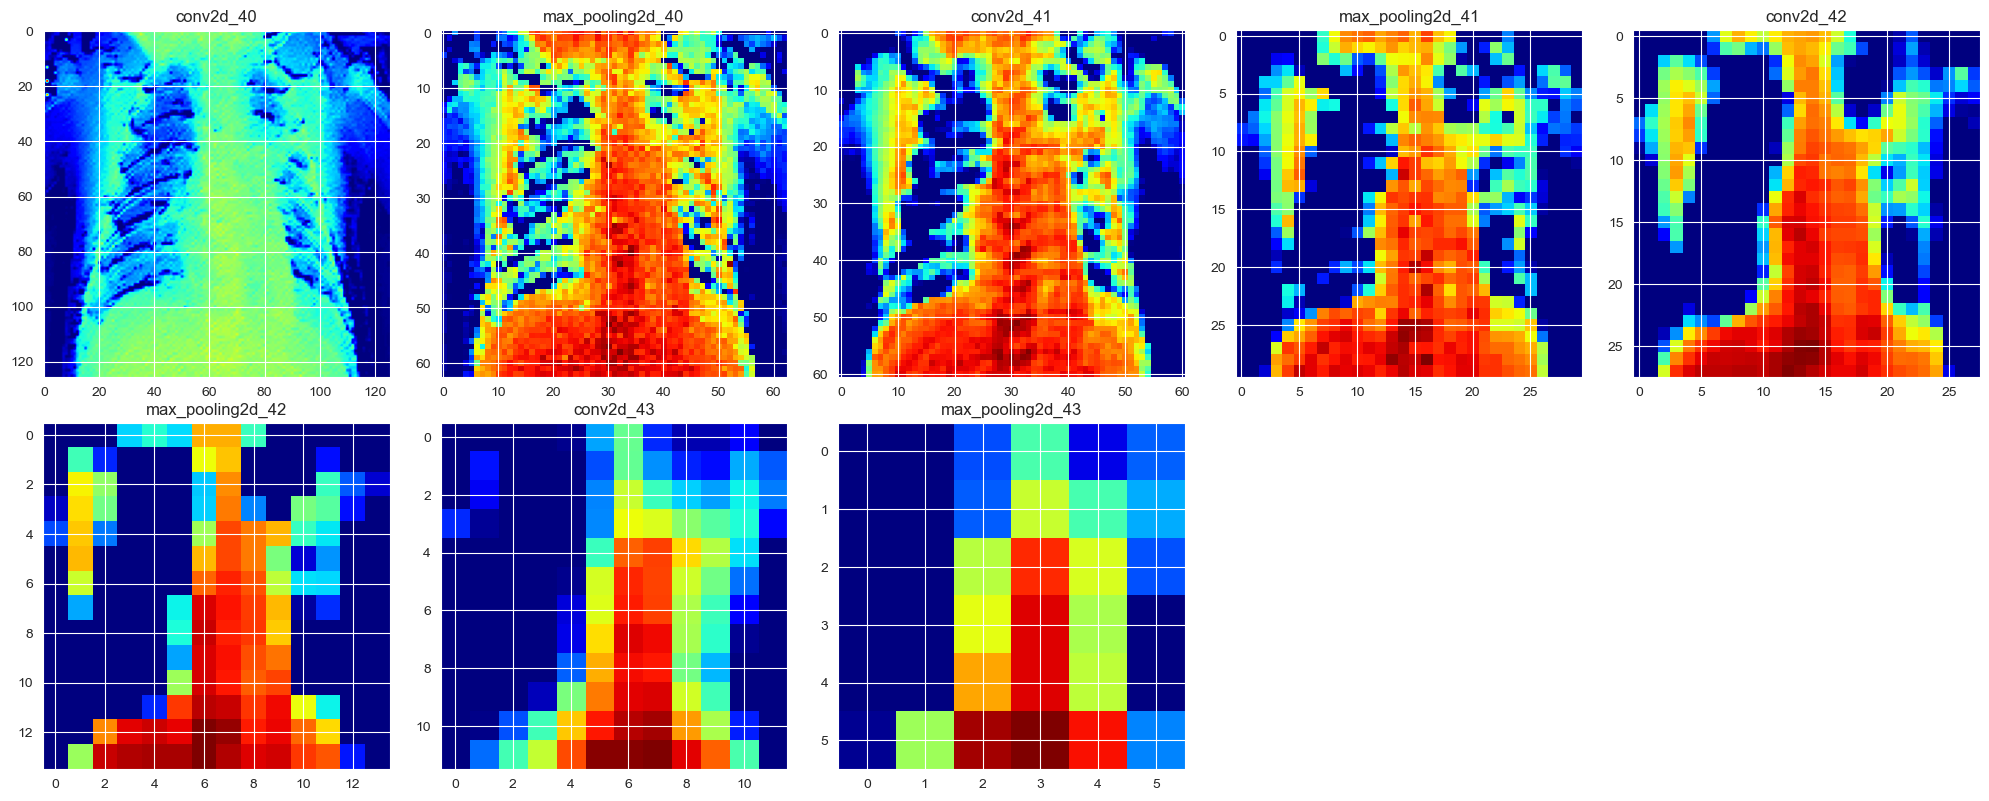

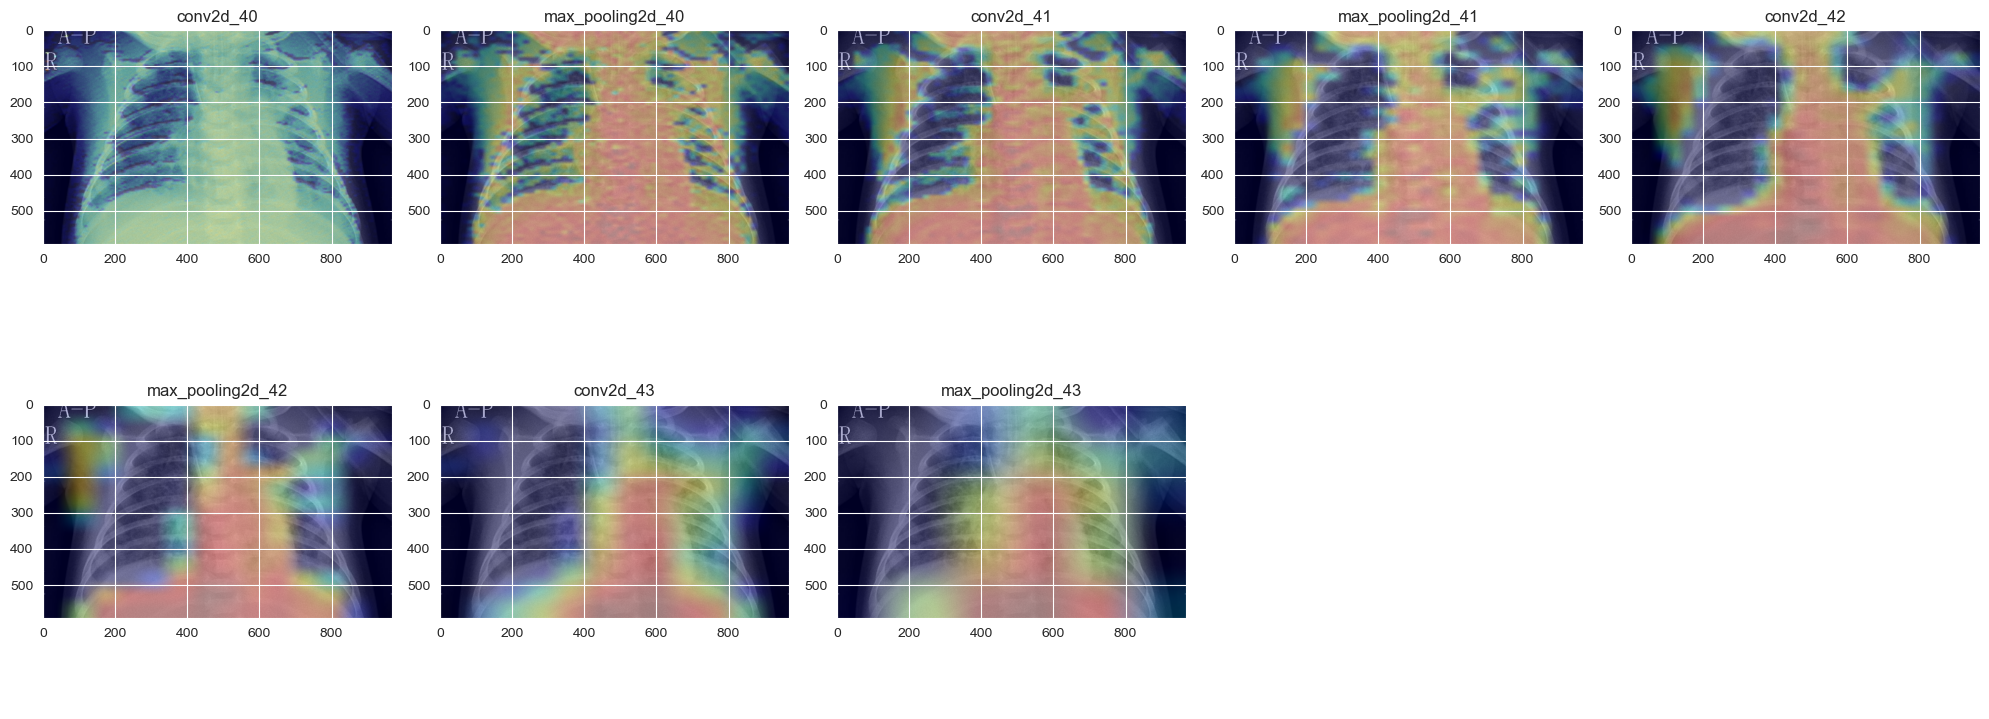

In [30]:
from common.cam import make_gradcam_heatmap, display_heatmaps

for image in images:
    heatmaps = []
    for layer in model.layers[:model.layers.index(model.get_layer(last_conv_layer_name)) + 1]:
        heatmap = make_gradcam_heatmap(image["array"], model, layer.name)
        heatmaps.append({
            "layer_name": layer.name,
            "image": heatmap
        })

    # Display heatmaps from all layers until the last max pooling layer
    display_heatmaps(image["path"], heatmaps)

    # Display the chosen image superimposed with heatmaps of each layer until the last max pooling layer
    display_heatmaps(image["path"], heatmaps, True)

In [31]:
# Predict
for image in images:
    pred = model.predict(image["array"].reshape(1, img_width, img_height, 1))
    print(pred)
    # Display predicted class
    print("Predicted class: {}".format(subfolders[int(pred[0][0])]))

1/1 [==============================] - 0s 373ms/step
[[0.]]
Predicted class: NORMAL
1/1 [==============================] - 0s 24ms/step
[[1.]]
Predicted class: PNEUMONIA
